## 1. Import Libraries

In [4]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
import os
import datetime
#from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from rdflib import Graph
from xml.dom import minidom
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

import random
import matplotlib.pyplot as plt

from SPARQLWrapper import SPARQLWrapper, JSON

from rdflib import Graph, URIRef
from rdflib.namespace import RDFS, SKOS

[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 103.0.5060
[WDM] - Get LATEST driver version for 103.0.5060
[WDM] - Get LATEST driver version for 103.0.5060
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/103.0.5060.53/chromedriver_mac64.zip
[WDM] - Driver has been saved in cache [/Users/frikha-s/.wdm/drivers/chromedriver/mac64/103.0.5060.53]


## 2. Retrieve a List of Target URLs

In [5]:
# parse the xml file
mydoc = minidom.parse('Sitemap.xml')
urls = mydoc.getElementsByTagName('ExpertLink')

with open('URLs.txt', 'w') as f:
    for u in urls:
        f.write(u.firstChild.data)
        f.writelines('\n')

In [6]:
mydoc = open('URLs.txt', 'r')
urls = mydoc.readlines()

## 3. Feed the RDF Graph

In [7]:
schema = Namespace("http://schema.org/")

In [41]:
## ratelimit decorator
from ratelimit import limits, RateLimitException, sleep_and_retry

five_by_seconds = 0.8

@sleep_and_retry
@limits(calls=1, period=five_by_seconds)
def ask_orphanet(u):
    wr = WebResource(url=u)
    print(wr.get_rdf())
    return wr.get_rdf()

In [42]:
%%time
KG_Total = ConjunctiveGraph()

for u in tqdm(urls):
    KG_Total += ask_orphanet(u)
    print(f"Loaded {len(KG_Total)} triples")

  0%|          | 0/10617 [00:00<?, ?it/s]

MaxRetryError: HTTPConnectionPool(host='127.0.0.1', port=63925): Max retries exceeded with url: /session/1f7df2c752bbce59c009c739b9eb360b/url (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7ff44e2779a0>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [38]:
##Display the total triples contained in the graph, after scrapping all URLs in the XML file
print(f"Loaded {len(KG_Total)} triples")

Loaded 0 triples


In [4]:
#Save the KG in a turtle file
KG_Total.serialize("orphanet_dump.ttl", format="turtle")

NameError: name 'KG_Total' is not defined

In [3]:
!cat orphanet_dump.ttl

@prefix ns1: <http://schema.org/> .

<http://www.orpha.net/consor/cgi-bin/OC_Exp.php?lng=en&Expert=118> a ns1:MedicalCondition ;
    ns1:alternateName "Beta-mannosidase deficiency" ;
    ns1:code [ a ns1:MedicalCode ;
            ns1:codeValue "ORPHA:118" ;
            ns1:codingSystem "ORPHAcode" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "C2931893" ;
            ns1:codingSystem "UMLS" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "E77.1" ;
            ns1:codingSystem "ICD-10" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "C0342849" ;
            ns1:codingSystem "UMLS" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "ORPHA:118" ;
            ns1:codingSystem "ORPHAcode" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "869" ;
            ns1:codingSystem "GARD" ],
        [ a ns1:MedicalCode ;
            ns1:codeValue "D044905" ;
            ns1:codingSystem "MeSH" ],
        [ a ns1:MedicalCode ;
            ns1:codeV

In [11]:
#Display the file's size
#!cat scrapped_orphanet_bioschemas.ttl
from pathlib import Path
file_size =Path(r'orphanet_dump.ttl').stat().st_size
print("The file size is:", file_size,"bytes")

The file size is: 82635 bytes


## 5. Display Bioschemas Properties Counts

In [11]:
def get_dataframe_from_query_results(res):    
    return pd.DataFrame(res.bindings)

In [1]:
### display used properties
property_counts = """
SELECT ?p (count(?p) as ?count) WHERE {
    ?s ?p ?o .
} 
GROUP BY ?p
ORDER BY DESC(?count)
"""

res = KG.query(property_counts)
print(res)
print("********** Used properties **********")
df = get_dataframe_from_query_results(res)
df

NameError: name 'KG' is not defined

## 6. Display Bioschemas Classes Counts

In [13]:
### display used classes
classes_counts = """
SELECT ?c (count(?c) as ?count) WHERE {
    ?s rdf:type ?c .
} 
GROUP BY ?c
ORDER BY DESC(?count)
"""

res = KG.query(classes_counts)
print()
print("********** Used classes **********")
df = get_dataframe_from_query_results(res)
df


********** Used classes **********


,c,count
0,http://schema.org/MedicalCode,64
1,http://schema.org/PronounceableText,20
2,http://schema.org/MedicalCondition,10


In [2]:
df = pd.DataFrame(res ,columns=['class','count'])

df["class"] = df["class"].astype("str")
df["count"] = df["count"].astype("int")
df.dtypes

NameError: name 'pd' is not defined

In [44]:
count_sum=94

def pourcentage(x):
          return x*100/count_sum
def get_suffix(x):
      return str(x).split(sep="/")[-1]

df2 = df.copy()
df2["%"] = df2['count'].apply(pourcentage)
df2["label"] = df2['class'].apply(get_suffix)
df2

,class,count,%,label
0,http://schema.org/MedicalCode,64,68.085106,MedicalCode
1,http://schema.org/PronounceableText,20,21.276596,PronounceableText
2,http://schema.org/MedicalCondition,10,10.638298,MedicalCondition


In [45]:
#Ordering for better visualisation
cols = df2.columns.tolist()
#cols = [cols[0], cols[3], cols[1], cols[2]]
cols = [cols[3], cols[1]]
df2 = df2[cols]
df2

,label,count
0,MedicalCode,64
1,PronounceableText,20
2,MedicalCondition,10


********** ********** Scatter Chart ********** **********


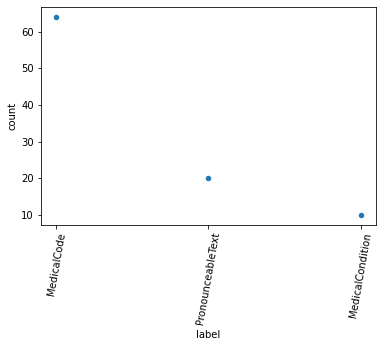

********** ********** Bar Chart ********** **********


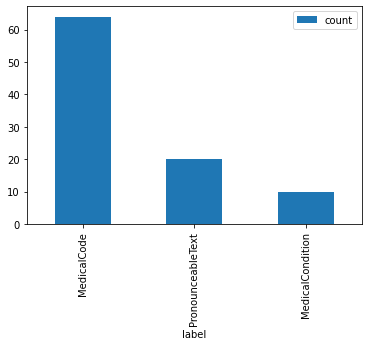

********** ********** Pie Chart ********** **********


<AxesSubplot:title={'center':'Pie Chart'}, ylabel='count'>

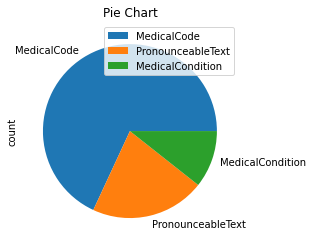

In [54]:
print("********** ********** Scatter Chart ********** **********")
df2.plot(x ='label', y='count', kind = 'scatter', rot=80)
plt.show()

print("********** ********** Bar Chart ********** **********")
df2.plot(x ='label', y='count', kind = 'bar')
plt.show()

print("********** ********** Pie Chart ********** **********")

my_labels=['MedicalCode','PronounceableText','MedicalCondition']
df2.plot.pie(title="Pie Chart",y='count',figsize=(4,4),labels=my_labels)

## For Further Visualizations
Have a look to Seaborn and Bokeh libraries
https://seaborn.pydata.org
https://bokeh.org